# NOT WORKING

In [1]:
import numpy as np
import pydot
import time
from IPython.display import SVG, display
from matplotlib import pyplot as plt
from pydrake.all import (
    Binding,
    DirectCollocation,
    DirectTranscription,
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    ConstantVectorSource,
    HPolyhedron,
    LinearConstraint,
    LinearSystem,
    MathematicalProgram,
    Point,
    eq,
    AddMultibodyPlantSceneGraph,
    BsplineTrajectory,
    CompositeTrajectory,
    PiecewisePolynomial,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MinimumDistanceLowerBoundConstraint,
    Parser,
    PositionConstraint,
    Rgba,
    RigidTransform,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
    SnoptSolver,
    SolverOptions,
    MultibodyPlant,
    SceneGraph,
    InputPort,
    RobotDiagramBuilder
)
from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddWsg
from underactuated import ConfigureParser, running_as_notebook

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7003


plant number of position and velocity: 3 3
plant num input ports:  12
geometry_query PortDataType.kAbstractValued
actuation PortDataType.kVectorValued
applied_generalized_force PortDataType.kVectorValued
applied_spatial_force PortDataType.kAbstractValued
WorldModelInstance_actuation PortDataType.kVectorValued
WorldModelInstance_desired_state PortDataType.kVectorValued
DefaultModelInstance_actuation PortDataType.kVectorValued
DefaultModelInstance_desired_state PortDataType.kVectorValued
iiwa14_actuation PortDataType.kVectorValued
iiwa14_desired_state PortDataType.kVectorValued
gripper_actuation PortDataType.kVectorValued
gripper_desired_state PortDataType.kVectorValued
optimization number of variables:  199
(6,)
input:  [Variable('u(0)', Continuous) Variable('u(1)', Continuous)
 Variable('u(2)', Continuous)]
state:  [Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous) Variable('x(3)', Continuous)
 Variable('x(4)', Continuous) Variable('x(5)', Continuo

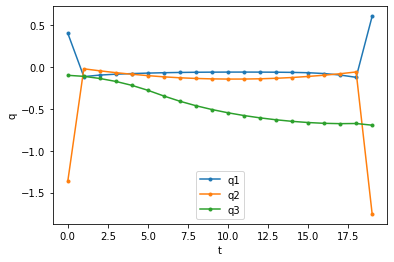

None

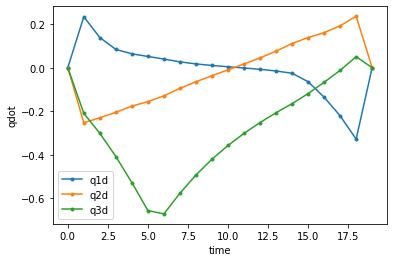

None

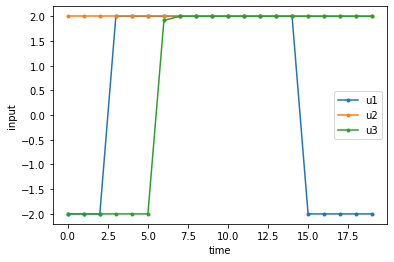

None

In [3]:
# direct collocation works only with continous-time 

def dircol_example(N, min_dt, max_dt):
    
    initial_state = [0.40236988, -1.36484125, -0.1, 0.0, 0.0, 0.0]
    final_state = [0.60544649, -1.75551969, -0.69582573, 0.0, 0.0, 0.0]

    ##################
    builder = RobotDiagramBuilder(time_step=0.0)
    ConfigureParser(builder.parser())
    iiwa = builder.parser().AddModelsFromUrl("package://drake_models/iiwa_description/urdf/planar_iiwa14_spheres_dense_elbow_collision.urdf")[0]
    
    plant = builder.plant()
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    
    assert plant.geometry_source_is_registered()

    # parser = Parser(plant_vis)
    # bin = parser.AddModelsFromUrl("file:///home/omid/drake/note/shelves.sdf")[0]
    # plant_vis.WeldFrames(
    #     plant_vis.world_frame(),
    #     plant_vis.GetFrameByName("shelves_body", bin),
    #     RigidTransform([0.88, 0, 0.4]),
    # )

    wsg = AddWsg(plant, iiwa, roll=0.0, welded=True, sphere=True)
    gripper_frame = plant.GetFrameByName("body", wsg)

    # Set default positions:
    # joint 1, 3, 5 and 7 are fixed to make kuka planar
    joint_2 = plant.GetMutableJointByName("iiwa_joint_2")
    joint_4 = plant.GetMutableJointByName("iiwa_joint_4")
    joint_6 = plant.GetMutableJointByName("iiwa_joint_6")
    joint_2.set_default_angle(initial_state[0])
    joint_4.set_default_angle(initial_state[1])
    joint_6.set_default_angle(initial_state[2])

    plant.Finalize()

    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    # print('diagram systems:')
    # display(
    #     SVG(
    #             pydot.graph_from_dot_data(diagram.GetGraphvizString ())[0].create_svg()
    #         )
    # )
    # print('plant topology:')
    # display(
    #     SVG(
    #         pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()
    #     )
    # )

    num_q = plant.num_positions()
    print('plant number of position and velocity:', plant.num_positions(), plant.num_velocities())
    # q0 = plant.GetPositions(plant_context)

    print('plant num input ports: ', plant.num_input_ports())
    for index in range(plant.num_input_ports()):
        port = plant.get_input_port(index)
        print(port.get_name(), port.get_data_type())

    # --- continuous
    dircol = DirectCollocation(
        diagram, # we do not have to explicitly set the dynamics as constraints. It does it by itself here
        diagram_context,
        num_time_samples=N,
        minimum_time_step=min_dt,
        maximum_time_step=max_dt,
        input_port_index = plant.get_actuation_input_port().get_index()
    )
    prog = dircol.prog()
    dircol.AddEqualTimeIntervalsConstraints()

    print('optimization number of variables: ', prog.num_vars())
    # print('decision variables:', prog.decision_variables())
    print(dircol.initial_state().shape)
    print('input: ', dircol.input())
    print('state: ', dircol.state())
    # boundary conditions
    prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())
    prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
    dircol.AddConstraintToAllKnotPoints(dircol.input()[0] <= 2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.input()[0] >= -2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.input()[1] <= 2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.input()[1] >= -2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.input()[2] <= 2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.input()[2] >= -2.0)
    
    dircol.AddConstraintToAllKnotPoints(dircol.state()[3] <= 2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.state()[3] >= -2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.state()[4] <= 2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.state()[4] >= -2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.state()[5] <= 2.0)
    dircol.AddConstraintToAllKnotPoints(dircol.state()[5] >= -2.0)

    dircol.AddRunningCost(dircol.input()[0] ** 2 + dircol.input()[1] ** 2 + dircol.input()[2] ** 2)
    dircol.AddFinalCost(dircol.time())

    # initial guess
    num_break_points = 12
    final_time = 5.0
    # linterp = np.linspace(initial_state, final_state, num_break_points)
    # print(linterp.shape)
    # initial_trajectory = PiecewisePolynomial.FirstOrderHold(
    #     np.linspace(0.0,final_time, num_break_points), 
    #     linterp.T
    # )

    initial_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((initial_state, final_state))
    )  # yapf: disable

    initial_u = PiecewisePolynomial()
    dircol.SetInitialTrajectory(initial_u, initial_trajectory)

    result = Solve(prog)
    print('solver name: ', result.get_solver_id().name())
    # OR:
    # solver = SnoptSolver()
    # solver_options = SolverOptions()
    # result = solver.Solve(prog, None, solver_options)

    print('optimal cost:', result.get_optimal_cost())
    # assert result.is_success()
        
    # Extract the solution
    timesteps = dircol.GetSampleTimes(result)
    states = dircol.GetStateSamples(result)
    inputs = dircol.GetInputSamples(result)
    print('trajectory shape:', states.shape)

    # we can recunstruct the solution trajectory:
    # u_trajectory = dircol.ReconstructInputTrajectory(result)
    # times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    # u_values = u_trajectory.vector_values(times)
    
    times = list(range(N))

    plt.figure()
    plt.plot(times, states[:3,:].T, label=["q1", "q2", "q3"], marker='.')
    plt.xlabel("t")
    plt.ylabel("q")
    plt.legend()
    display(plt.show())

    plt.figure()
    plt.plot(times, states[3:,:].T, label=["q1d", "q2d", "q3d"], marker='.')
    plt.xlabel("time")
    plt.ylabel("qdot")
    plt.legend()
    display(plt.show())

    plt.figure()
    plt.plot(times, inputs.T, label=["u1", "u2", "u3"], marker='.')
    plt.xlabel("time")
    plt.ylabel("input")
    plt.legend()
    display(plt.show())

    #============= visualization
    meshcat.Delete()

    builder2 = DiagramBuilder()
    plant2, scene_graph2 = AddMultibodyPlantSceneGraph(builder2, 0.0) 
    parser = Parser(plant2)
    iiwa2 = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/planar_iiwa14_spheres_dense_elbow_collision.urdf"
    )[0]
    plant2.WeldFrames(plant2.world_frame(), plant2.GetFrameByName("iiwa_link_0"))

    
    wsg = AddWsg(plant2, iiwa2, roll=0.0, welded=True, sphere=True)
    plant2.Finalize()

    X_WStart = RigidTransform([0.8, 0, 0.65])
    meshcat.SetObject("start", Sphere(0.02), rgba=Rgba(0.9, 0.1, 0.1, 1))
    meshcat.SetTransform("start", X_WStart)
    X_WGoal = RigidTransform([0.8, 0, 0.4])
    meshcat.SetObject("goal", Sphere(0.02), rgba=Rgba(0.1, 0.9, 0.1, 1))
    meshcat.SetTransform("goal", X_WGoal)

    visualizer = MeshcatVisualizer.AddToBuilder( 
        builder2, scene_graph2, meshcat,
        MeshcatVisualizerParams(role=Role.kPerception, prefix="visual")
    )

    diagram2 = builder2.Build()
    diagram_context2 = diagram2.CreateDefaultContext()
    plant_context2 = plant2.GetMyContextFromRoot(diagram_context2)
    # collision_visualizer = MeshcatVisualizer.AddToBuilder(
    #     builder,
    #     scene_graph,
    #     meshcat,
    #     MeshcatVisualizerParams(
    #         prefix="collision", role=Role.kProximity, visible_by_default=False
    #     ),
    # )

    while True:
        # Just keep playing back the trajectory
        for i in range(len(timesteps)):
            t = timesteps[i]
            x = states[:,i]
            diagram_context2.SetTime(t)
            plant2.SetPositionsAndVelocities(plant_context2, x)
            diagram2.ForcedPublish(diagram_context2)

            time.sleep(plant.time_step())

            # sleep at the initial state, its better visualiztion
            if i == 0:
                time.sleep(3)
        time.sleep(3)

N = 20
dircol_example(N, min_dt=0.5/N, max_dt=2.0/N)